In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import SR1, BFGS
from scipy.optimize import minimize

import confound_mdp
import confound_ope
import confound_env

from core.sepsisSimDiabetes.State import State
from core.sepsisSimDiabetes.Action import Action
from core import generator_confounded_mdp as DGEN
from core import conf_wis as CWIS
from core import loss_minimization as LB
from utils.utils import *

# Lower Bound Experiments

In [2]:
# want an evaluation policy that's better than the behavioral policy
# BUT with unobserved confounding the lower bound on the eval policy is worse than the behavioral policy
#    this is the scenario where the different sensitivity models matter in practice
#    e.g. for policy optimization

In [3]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]

pi_b, P, R, x_dist, u_dist, gamma = confound_env.toy227(0.25, 0.35)
toy = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
horizon = 5
nStates = P.shape[2]
nActions = P.shape[1]
pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([toy, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])

horizon = 4
graph_len = 4
pi_b, P, R, x_dist, u_dist, gamma = confound_env.graph_opetools(horizon=graph_len, slip=0.25, confound_weight=0.23)
R = -1*R
graph = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([graph, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])

horizon = 20
pi_b, P, R, x_dist, u_dist, gamma = confound_env.toymc_opetools(n_left=8, n_right=8, horizon=20, slip=0.15, confound_weight=0.6)
#R = -1*R
toymc = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.15, 0.85]
    
envs.append([toymc, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])

horizon = 8
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0, confound_weight=0)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])


In [4]:
fqe_envs = []
mb_envs = []

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

#hadds = [0, 5, 10]
hadds = [0]

for mdp , pi_b, pi_e, base_horizon, gamma, nStates, nActions, term in [envs[-1]]:
    
    print("---")
    
    for h in hadds:
        horizon = base_horizon + h
        
        print("running env with horizon " + str(horizon))

        dataset = confound_mdp.collect_sample(int(30000/horizon), mdp, pi_b, horizon)
        data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
        Phat = confound_ope.estimate_P(dataset, mdp)
        pihat = confound_ope.estimate_pi(dataset, mdp)
        for a in range(nActions):
            for s in range(nStates):
                if Phat[a,s].sum() == 0:
                    Phat[a,s,term] = 1
                if pihat[s].sum() == 0:
                    pihat[s,:] = 1/nActions
        pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())

        # no confounding:
        print("value of pi_e with no confounding")
        Q0 = np.zeros((nStates, nActions))
        nom_q = Q0.copy()
        for t in range(horizon):
            nom_q = confound_ope.fitted_q_update(nom_q, pi_e, dataset, mdp)
        print(mdp.get_value(nom_q,pi_e)[1])

        fqe_results = np.zeros((nGams))

        print("now running C-FQE")
        for i,gam in enumerate(gams):
            Q0 = np.zeros((nStates, nActions))
            q_reparam_samp = Q0.copy()
            for t in range(horizon):
                q_reparam_samp = confound_ope.fitted_q_update_reparam_sampling(q_reparam_samp, pi_e, pihat, Phat, gam, data, mdp)
            fqe_results[i] = mdp.get_value(q_reparam_samp,pi_e)[1]

        '''
        print("now running robust mdps...")
        mb_results = np.zeros((nGams, nPbs))

        for i,gam in tqdm(enumerate(gams)):
            for j,P_bound in enumerate(Pbs):
                V0 = np.zeros(nStates)
                fixed_u_v = V0.copy()
                for t in range(horizon):
                    fixed_u_v = confound_ope.fixed_u_gp_s_rect(fixed_u_v, pi_e, 0.50, Phat, pihat, P_bound, gam, mdp)
                mb_results[i,j] = fixed_u_v @ mdp.x_dist

        fqe_envs.append(fqe_results)
        mb_envs.append(mb_results)
        '''

---
running env with horizon 8
value of pi_b
-0.6015843309291272
value of pi_e with no confounding
-0.2073855206450719
now running C-FQE


# Here's where our work starts

So, here's what I think is going on. For the Gridworld problem, we have a 4x4 gridworld. 
`nStates` is 16, and `nActions` is 4. Of the things we're interested in, 
$$\mathbb{P} \in \mathbb{R}^{U \times A \times  S \times S'}, R \in \mathbb{R}^{A \times S \times S'}, \pi_b \in \mathbb{R}^{U \times S \times  A}, \pi_e \in \mathbb{R}^{S \times A}$$

`P` sums to 128. That, divided by `nStates` and then `nActions`, yields 2. I think then, that `P` gives the conditional transition probabilities given the selection of hidden state $U$.

`Phat` and `pihat` are estimates of the transition probabilities and behavior policy respectively with $U$ marginalized out. `Phat` sums to 64, and is given by the same calculation method of $N(s, a, s')/N(s, a)$ as $\hat{\mathbb{P}}_{\pi_b}(s' | s, a)$, so we can conclude that it is that. Permuting axes to be ordered (s', s, a) gives us `P_ssa`. Additionally, `pihat[a, s]` really gives $\hat{\pi_b}(a | s)$. 

Define `R_sa` to be the array of rewards for each state-action pair. David sets `R[:, i, :]` to be a flattened copy of the grid. That's not really what we're interested in, but we can average the transition probabilities among the distribution of u, take the element-wise product with the `R` array, sum it over the $S'$ axis and take the transpose to obtain `R_sa`.

Actions are indexed WENS

In [5]:
# This is the actual reward_sa
R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
R_sa

array([[-0.01 , -0.01 , -0.01 , -0.01 ],
       [-0.01 , -0.01 , -0.01 , -0.01 ],
       [-0.01 , -0.01 , -0.01 , -0.005],
       [-0.01 , -0.01 , -0.01 , -0.5  ],
       [-0.01 , -0.01 , -0.01 , -0.01 ],
       [-0.01 , -0.005, -0.01 , -0.5  ],
       [-0.01 , -0.5  , -0.01 , -0.01 ],
       [-0.005, -0.5  , -0.01 , -0.5  ],
       [-0.01 , -0.5  , -0.01 , -0.01 ],
       [-0.01 , -0.01 , -0.01 , -0.5  ],
       [-0.5  , -0.5  , -0.005, -0.005],
       [-0.01 , -0.5  , -0.5  ,  1.   ],
       [-0.01 , -0.5  , -0.01 , -0.01 ],
       [-0.01 , -0.005, -0.5  , -0.5  ],
       [-0.5  ,  1.   , -0.01 , -0.005],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

In [6]:
# This is the estimated reward(s, a)
R_sa = (Phat * confound_ope.estimate_R(dataset, mdp)).sum(axis=2).T
R_sa

array([[-0.01 , -0.01 , -0.01 , -0.01 ],
       [-0.01 , -0.01 , -0.01 , -0.01 ],
       [-0.01 , -0.01 , -0.01 , -0.005],
       [-0.01 , -0.01 , -0.01 , -0.5  ],
       [-0.01 , -0.01 , -0.01 , -0.01 ],
       [-0.01 , -0.005, -0.01 , -0.5  ],
       [-0.01 , -0.5  , -0.01 , -0.01 ],
       [-0.005, -0.5  , -0.01 , -0.5  ],
       [-0.01 , -0.5  , -0.01 , -0.01 ],
       [-0.01 , -0.01 , -0.01 , -0.5  ],
       [-0.5  , -0.5  , -0.005, -0.005],
       [-0.01 , -0.5  , -0.5  ,  1.   ],
       [-0.01 , -0.5  , -0.01 , -0.01 ],
       [-0.01 , -0.005, -0.5  , -0.5  ],
       [-0.5  ,  1.   , -0.01 , -0.005],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

In [7]:
np.mean((Phat - np.average(P, axis=0, weights=u_dist))**2)
gam = gams[0]
alpha_sa = pihat + (1/gam) * (1-pihat)
beta_sa = gam + pihat*(1-gam)

In [8]:
P_spsa = Phat.transpose((2, 1, 0))
n = data.shape[0]

In [9]:
N_sa = np.zeros((nActions, nStates))
for x,a,u,xp,r in data:
    N_sa[int(a), int(x)] += 1
N_sa = N_sa.astype(int).T

In [10]:
delta = 0.05

In [11]:
G_lb = alpha_sa*(P_spsa - np.sqrt(np.reciprocal(2*N_sa) * np.log((2*n*(nStates**2)*nActions)/delta)))
G_ub = beta_sa*(P_spsa - np.sqrt(np.reciprocal(2*N_sa) * np.log((2*n*(nStates**2)*nActions)/delta)))

In [12]:
np.all(G_lb <= P_spsa) and np.all(P_spsa <= G_ub)

True

In [13]:
s = 0

pi_e[s]
R_sa[s]
P_spsa[:, s, :].T
np.ones(nStates)

pi_e[s].T @ (R_sa[s])

-0.00999999999999987

In [14]:
so = 2
pi_e[so,:] @ R_sa[so,:]

-0.00949999999999993

In [15]:
for s in range(nStates):
    print(sum([pi_e[s, a]*R_sa[s, a] for a in range(nActions)]))

-0.009999999999999872
-0.009999999999999886
-0.009499999999999929
-0.05899999999999996
-0.009999999999999834
-0.05849999999999992
-0.05899999999999996
-0.10600000000000001
-0.05899999999999985
-0.058999999999999955
-0.2525
-0.154
-0.05899999999999986
-0.25449999999999995
-0.10450000000000001
0.0


In [65]:
import gurobipy as gp
from gurobipy import GRB

so = 0

m = gp.Model()
m.setParam('NonConvex', 2)
m.setParam('Presolve', 0)
m.setParam('NumericFocus', 3)
m.setParam('BarHomogenous', 1)
#m.setParam('BarCorrectors', 1000)
m.setParam('OptimalityTol', 1e-9)
m.setParam('FeasibilityTol', 1e-9)
m.setParam('BarConvTol', 1e-9)
m.setParam('BarQCPConvTol', 1e-9)

# V_2, ... , V_H <=> [0, ..., H-1), H-1 x S sized
#V = m.addVars(horizon - 1, nStates) 
V = m.addVars(horizon, nStates) 
Prob_spsa = m.addVars(nStates, nStates, nActions)

# Prob matrix membership constraint
for sp in range(nStates):
    for s in range(nStates):
        for a in range(nActions):
            m.addConstr(float(G_lb[sp, s, a]) <= Prob_spsa[sp, s, a], 
                        'LB_G_Membership'+str(sp)+str(s)+str(a))
            m.addConstr(Prob_spsa[sp, s, a] <= float(G_ub[sp, s, a]), 
                        'UB_G_Membership'+str(sp)+str(s)+str(a))

# Prob matrix row sum constraint
for s in range(nStates):
    for a in range(nActions):
        m.addConstr(gp.quicksum([Prob_spsa[sp, s, a] 
                                 for sp in range(nStates)]) == 1, 
                    'Row_Sum'+str(s)+str(a))

# V_H+1 = 0 constraint, for h = H to force V_H+1 to be 0
# Also implements S Bellman Backup constraints for V_H
# Unfortunately, it seems like these constraints make the model infeasible
#for s in range(nStates):
    # We want V_H+1 = 0, but we started indexing V_2 at 0
    # So V_H+1 would be located at V[H-1] if it existed
    # But we're setting it to 0, so we can pretend the sum over sp doesn't exist
    # What's on the LHS then? V_H. That corresponds to V[H-2, s].
#    m.addConstr(V[horizon-2, s] == gp.quicksum([pi_e[s, a]*R_sa[s, a]
#                                                for a in range(nActions)]), 
#                                                'H+1'+str(s))

for s in range(nStates):
    m.addConstr(V[horizon-1, s] == 0)

# Bellman Backup constraints: H-2 x S ordinary constraints for h = 2,...,H-1
# Constraints (1 x S of them) for h = H implemented earlier in V_H+1 = 0 constraint
#for h in range(horizon-2):
for h in range(horizon-1):
    for s in range(nStates):
        m.addConstr(V[h, s] == gp.quicksum([pi_e[s, a]*R_sa[s, a]
                                            for a in range(nActions)]) + 
                               gp.quicksum([pi_e[s, a]*Prob_spsa[sp,s,a]*V[h+1,sp] 
                                            for a in range(nActions) 
                                            for sp in range(nStates)]),
                               'Backup'+str(h)+str(s))
        #m.addConstr(V[h, s] == gp.quicksum([pi_e[s, a]*(R_sa[s, a] + Prob_spsa[sp,s,a]*V[h+1,sp]) 
        #                                    for a in range(nActions) 
        #                                    for sp in range(nStates)]), 
        #                                'Backup'+str(h)+str(s))

# Directly maximize the quadratic form for V_1(s0). 
# Substitute so for what we previously called s. 
# We need V_2(\cdot) in the RHS, so as before subtract 2 and take V[0, sp]
obj = (gp.quicksum([pi_e[so, a]*R_sa[so, a] 
                    for a in range(nActions)]) + 
        gp.quicksum([pi_e[so, a]*Prob_spsa[sp,so,a]*V[0,sp] 
                    for a in range(nActions) 
                    for sp in range(nStates)]))
m.setObjective(obj, GRB.MINIMIZE)


m.optimize()


Set parameter NonConvex to value 2
Set parameter Presolve to value 0
Set parameter NumericFocus to value 3
No parameters matching 'BarHomogenous' found
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter BarConvTol to value 1e-09
Set parameter BarQCPConvTol to value 1e-09
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2128 rows, 1152 columns and 3088 nonzeros
Model fingerprint: 0xf58defd6
Model has 64 quadratic objective terms
Model has 112 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-01, 4e-01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-01, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 1e+00]
  QRHS range       [9e-03, 3e-01]

Continuous model is non-convex -- solving as a MIP

Variable types: 8370 con

In [63]:
m.printStats()


Statistics for modelUnnamed:
  Linear constraint matrix    : 2128 Constrs, 1152 Vars, 3088 NZs
  Quadratic constraints       : 112 Constrs, 7280 NZs
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0, 0 ]
  Variable bound range        : [ 0, 0 ]
  RHS coefficient range       : [ 0.919679, 1.08835 ]


In [34]:
m

<gurobi.Model MIP instance Unnamed: 2128 constrs, 1152 vars, Parameter changes: FeasibilityTol=0.0001, OptimalityTol=0.0001, GomoryPasses=0, NonConvex=2, NumericFocus=3, Presolve=0>

In [35]:
#model is infeasible
m.computeIIS()


Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0      2240         -         0      1152         -           0s
        0      1095         -         0      1151         -           6s
        0       888        10         0      1149         -          10s
        0       888        10         0      1149         -          15s
        0       888        10         0      1149         -          21s
        0       800        10         0      1149         -          26s
        0       800        10         0      1149         -          30s
        0       800        10         0      1149         -          40s
        0       800        10         0      1149         -          44s
        0       800        10         0      1149         -          51s
  

In [43]:
#m.feasRelaxS(1, True, False, True)

0.0

In [563]:
m.write('model.ilp')

In [21]:
(horizon - 2) * nStates

96

In [212]:
%load_ext autoreload
%autoreload 2

In [11]:
import pickle

pickle.dump( fqe_envs, open( "fqe_horizon_experiments.p", "wb" ) )
pickle.dump( mb_envs, open( "mb_horizon_experiments.p", "wb" ) )

In [6]:
#fqe_envs = pickle.load( open( "fqe_horizon_experiments.p", "rb" ) )
#mb_envs = pickle.load( open( "mb_horizon_experiments.p", "rb" ) )

In [7]:
# select only base horizon
#fqe_envs = fqe_envs[::3]
#mb_envs = mb_envs[::3]
fqe_envs = feq_envs[0]
mb_envs = mb_envs[0]

In [8]:
pi_e_vals = [0.499015492905087 , 0.7174129322887378, -15.738140536232656, -0.35692764811666317]
pi_b_vals = [0.33965256189333337 , -0.178639828, -18.189038465627075, -0.49942501436258074]

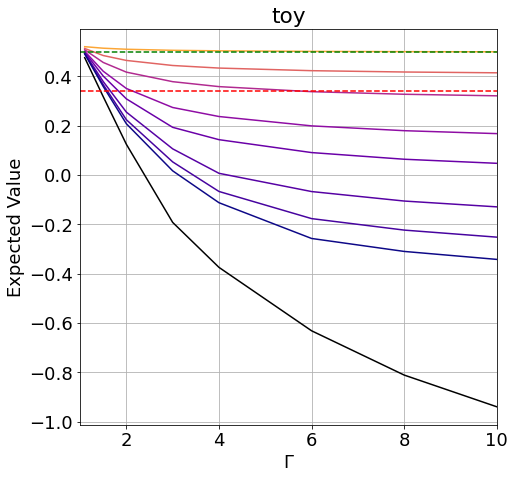

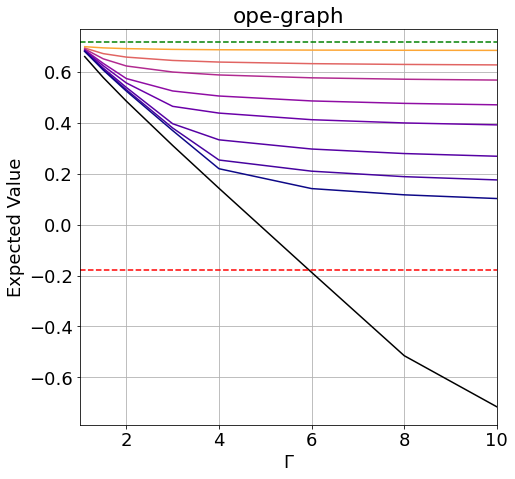

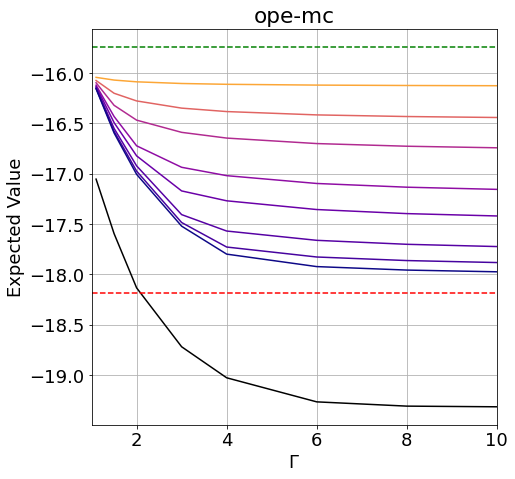

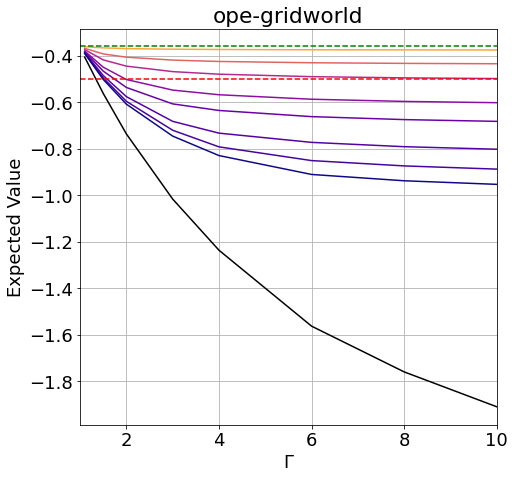

In [10]:
from matplotlib import colors

import matplotlib
matplotlib.rcParams.update({'font.size': 18})

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

Pbs_ext = np.insert(Pbs,0,0)

deltacol = np.flip(plt.cm.plasma(Pbs_ext / np.amax(Pbs) ), axis=0)

count = 0
envTitles = ["toy", "ope-graph", 'ope-mc', 'ope-gridworld']
for fqe_results, mb_results in zip(fqe_envs,mb_envs):
    fig = plt.figure()
    fig.set_size_inches(7.5, 7)
    plt.plot(gams,fqe_results, color='k')
    for p in range(nPbs):
        plt.plot(gams, mb_results[:,p], color=deltacol[p+1], label="{:.1f}".format(Pbs[p]))
    plt.axhline(pi_e_vals[count], color='green', linestyle='--')
    plt.axhline(pi_b_vals[count], color='red', linestyle='--')
    plt.ylabel("Expected Value")
    plt.xlabel("$\Gamma$")
    plt.xlim([1,10])
    plt.title(envTitles[count])
    plt.grid()
    plt.tight_layout()
    #fig.savefig("cam_ready_lower_bound_plot_%s.pdf" % count)
    count += 1